In [19]:
#Загрузим необходимые библиотеки и посмотрим несколько первых строк нашего датасета
from matplotlib import ticker as mtick
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
data = pd.read_csv("Sample - Superstore.csv", encoding='latin1')
data.head(3)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [4]:
#Приведем названия столбцов к общему виду(нижний регистр, нижнее подчеркивание вместо пробела) и выведем их
data.columns = data.columns.str.replace(" ", "_").str.lower()
data.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub-category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

In [5]:
#Уберем несколько столбцов, не нужных для нашего анализа
data = data.drop(columns=["row_id", "customer_name"])

In [6]:
#Проверим, есть ли повторяющиеся строки
data[data.duplicated()]

,order_id,order_date,ship_date,ship_mode,customer_id,segment,country,city,state,postal_code,region,product_id,category,sub-category,product_name,sales,quantity,discount,profit
3406,US-2014-150119,4/23/2014,4/27/2014,Standard Class,LB-16795,Home Office,United States,Columbus,Ohio,43229,East,FUR-CH-10002965,Furniture,Chairs,Global Leather Highback Executive Chair with P...,281.372,2,0.3,-12.0588


In [7]:
#Удалим все повторяющиеся строки
data = data.drop_duplicates()

Text(0.5, 1.0, 'Доля общей прибыли по категориям')

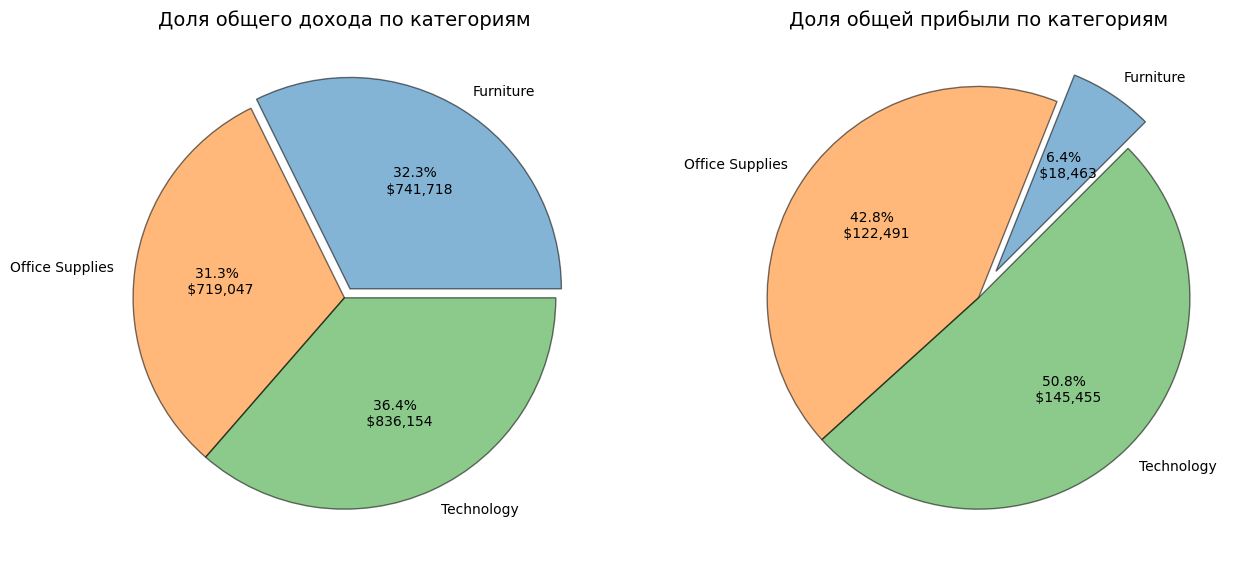

In [9]:
#Группируем по категории и суммируем все числовые столбцы (sales, profit и т.д.) для каждой группы
sales_per_category = data.groupby("category").sum()

#Строим круговые диаграммы продаж и прибыли
category_colors = ["tab:blue" if label == "Furniture" else "tab:orange" if label == "Office Supplies" else "tab:green" for label in sales_per_category.index]
fig, (ax1, ax2) = plt.subplots(figsize=(15, 15), ncols=2)

ax1.pie(sales_per_category["sales"], labels=sales_per_category.index,
      autopct=lambda p:f"{p:.1f}% \n ${p*np.sum(sales_per_category['sales'])/100 :,.0f}",
      wedgeprops={"linewidth": 1, "edgecolor":"black", "alpha":0.55},
      colors=category_colors, explode=[0.05, 0, 0])

ax1.set_title("Доля общего дохода по категориям", fontdict={"fontsize":14})

ax2.pie(sales_per_category["profit"], labels=sales_per_category.index,
       autopct=lambda p: f"{p:.1f}% \n ${p*np.sum(sales_per_category['profit'])/100 :,.0f}",
        startangle=45, wedgeprops={"linewidth": 1, "edgecolor":"black", "alpha":0.55},
        colors=category_colors, explode=[0.15, 0, 0])

ax2.set_title("Доля общей прибыли по категориям", fontdict={"fontsize":14})

Заметим, что объем продаж распределен практически равномерно среди категорий товаров. Тем не менее, если рассмотреть вклад каждой категории в общую прибыль, становится ясно, что маржа мебели значительно ниже, чем у канцтоваров и технологий.
Исходя из этого, рассмотрим подкатегории и их маржинальность.

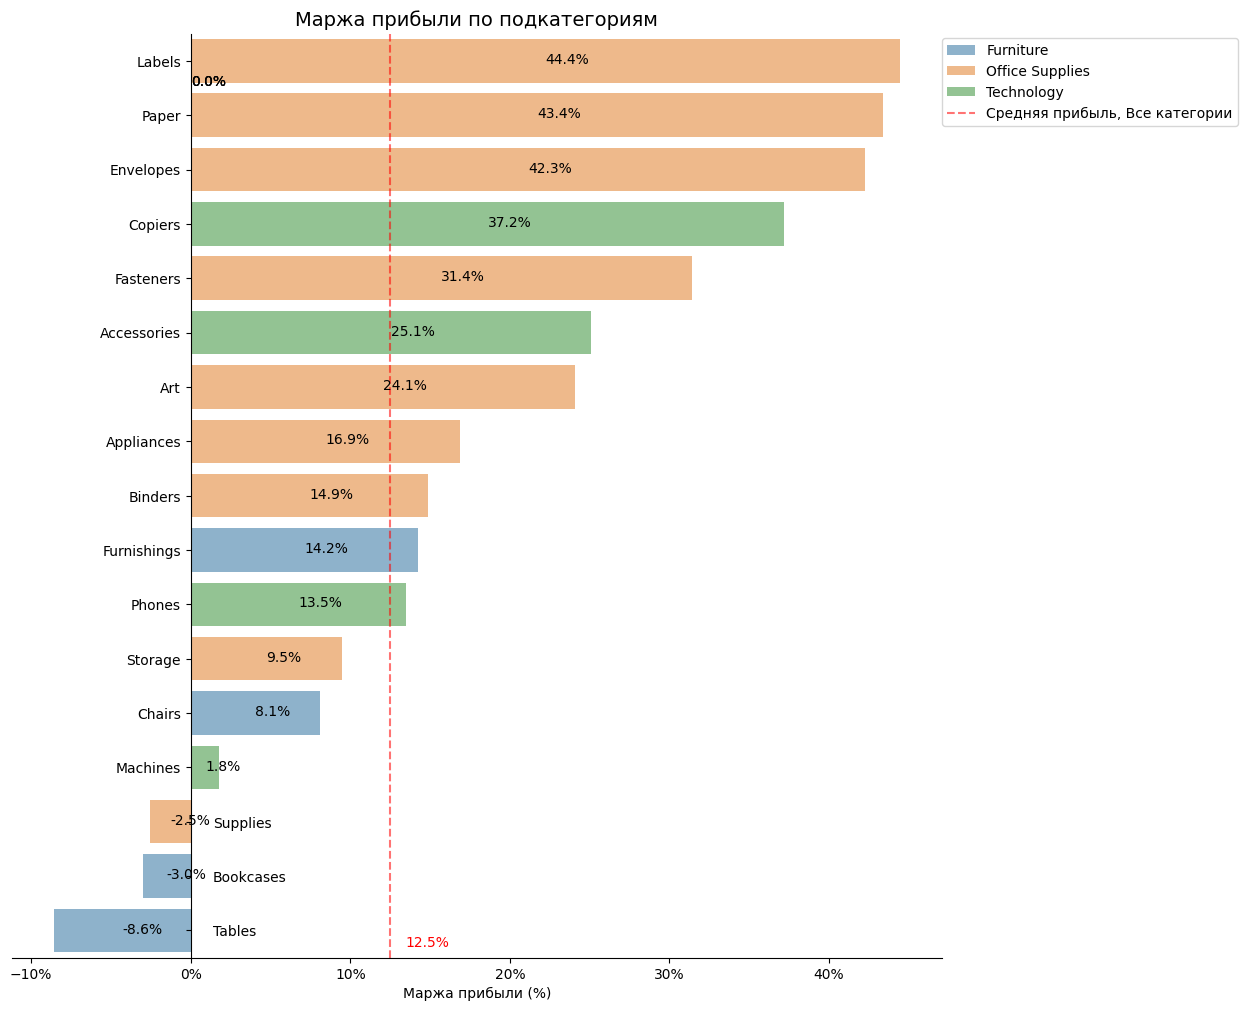

In [10]:
#Группируем данные по категориям и подкатегориям, суммируем, находим маржу прибыли и сортируем
sales_per_subcategory = data.groupby(["category", "sub-category"], as_index=False)[["sales", "profit"]].sum()
sales_per_subcategory["profit_margin"] = sales_per_subcategory["profit"] / sales_per_subcategory["sales"]
sales_per_subcategory.sort_values(by="profit_margin", inplace=True, ascending=False)

#Создаем диаграмму
fig, ax = plt.subplots(figsize=(12,12))

sns.barplot(y=sales_per_subcategory["sub-category"], x=sales_per_subcategory["profit_margin"], hue=sales_per_subcategory["category"],
            hue_order=["Furniture", "Office Supplies", "Technology"], alpha=0.55, dodge=False,
           ax=ax)

ax.spines["left"].set_position("zero")
ax.spines[["right","top"]].set_visible(False)
ax.set(ylabel=None, xlabel="Маржа прибыли (%)")


def move_ylabel_tick(index: list):
    for tick in index:
        ax.get_yticklabels()[tick].set_x(0.02)
        ax.get_yticklabels()[tick].set_horizontalalignment("left")

move_ylabel_tick([-1, -2, -3])

for p in ax.patches:
    _, y = p.get_xy()

    ax.annotate(f"{p.get_width()*100 :.1f}%", (p.get_width() / 2, y+0.45))

#Рассчитываем общую среднюю маржу прибыли по всему магазину (сумма всех прибылей / сумма всех продаж) и рисуем ее на графике
mean_profit = sales_per_subcategory["profit"].sum() / sales_per_subcategory["sales"].sum()

ax.axvline(mean_profit, color="red", label="Средняя прибыль, Все категории", alpha=0.55, ls="--")
ax.text(x=mean_profit+0.01, y=len(sales_per_subcategory)-0.7, s=f"{mean_profit*100 :.1f}%", color="red")

ax.set_title("Маржа прибыли по подкатегориям", fontdict={"fontsize":14})
ax.legend(loc=(1, 0.9))

ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

Приведённая выше столбчатая диаграмма показывает, что компания получает очень высокую маржу (в два раза превышают общую маржу по компании) на нескольких подкатегориях: товары для офиса (канцелярские принадлежности), а также технологии(Copiers, Accessories). Диаграмма показывает, что маржа прибыли в подкатегориях мебели остаётся низкой, а две из них даже продаются с убытком.
Теперь рассмотрим подкатегории, где комания несет убытки.

In [11]:
#Создаем отдельные датасеты для каждой из убыточных подкатегорий
tables = data.groupby(["sub-category", "product_name"]).sum().loc["Tables",:]
bookcases = data.groupby(["sub-category", "product_name"]).sum().loc["Bookcases",:]
supplies = data.groupby(["sub-category", "product_name"]).sum().loc["Supplies",:]

#Считаем маржу прибыли наших новых датасетов
def profit_margin(category_df):

    category_df["profit_margin"] = category_df["profit"] / category_df["sales"]
    category_df.sort_values(by="profit_margin", inplace=True, ascending=False)
    return category_df

profit_margin(tables)
profit_margin(bookcases)
profit_margin(supplies)

#Для каждой подкатегории считаем и печатаем, сколько продуктов имеют маржу прибыли выше средней по компании (mean_profit), и сколько всего продуктов в этой подкатегории
def profitable_items(category_dict: dict):

    for df_name, df in category_dict.items():
        print(f"""{df_name} имеет {len(df[df['profit_margin'] > mean_profit])} предмета(ов) (из {len(df)}), для которых маржа прибыли выше средней по компании.""")

profitable_items({"Tables":tables, "Bookcases":bookcases, "Supplies":supplies})

Tables имеет 2 предмета(ов) (из 56), для которых маржа прибыли выше средней по компании.
Bookcases имеет 6 предмета(ов) (из 50), для которых маржа прибыли выше средней по компании.
Supplies имеет 23 предмета(ов) (из 36), для которых маржа прибыли выше средней по компании.


Из трёх подкатегорий, которые этот супермаркет продаёт с убытком, Tables и Bookcases являются самыми невыгодными, а большинство товаров из Supplies (Канцелярские принадлежности) продаются с маржой выше средней по компании.
Рассмотрим топ-15 товаров с самыми высокими маржами в каждой из этих подкатегорий.

/tmp/ipython-input-2943197361.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=tables.index[:15], x=tables["profit_margin"][:15], ax=ax1,
/tmp/ipython-input-2943197361.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=bookcases.index[:15], x=bookcases["profit_margin"][:15], ax=ax2,
/tmp/ipython-input-2943197361.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=supplies.index[:15], x=supplies["profit_margin"][:15], ax=ax3,
/tmp/ipython-input-2943197361.py:14: UserWarning: set_ticklabels() should only be used with a fixed number o

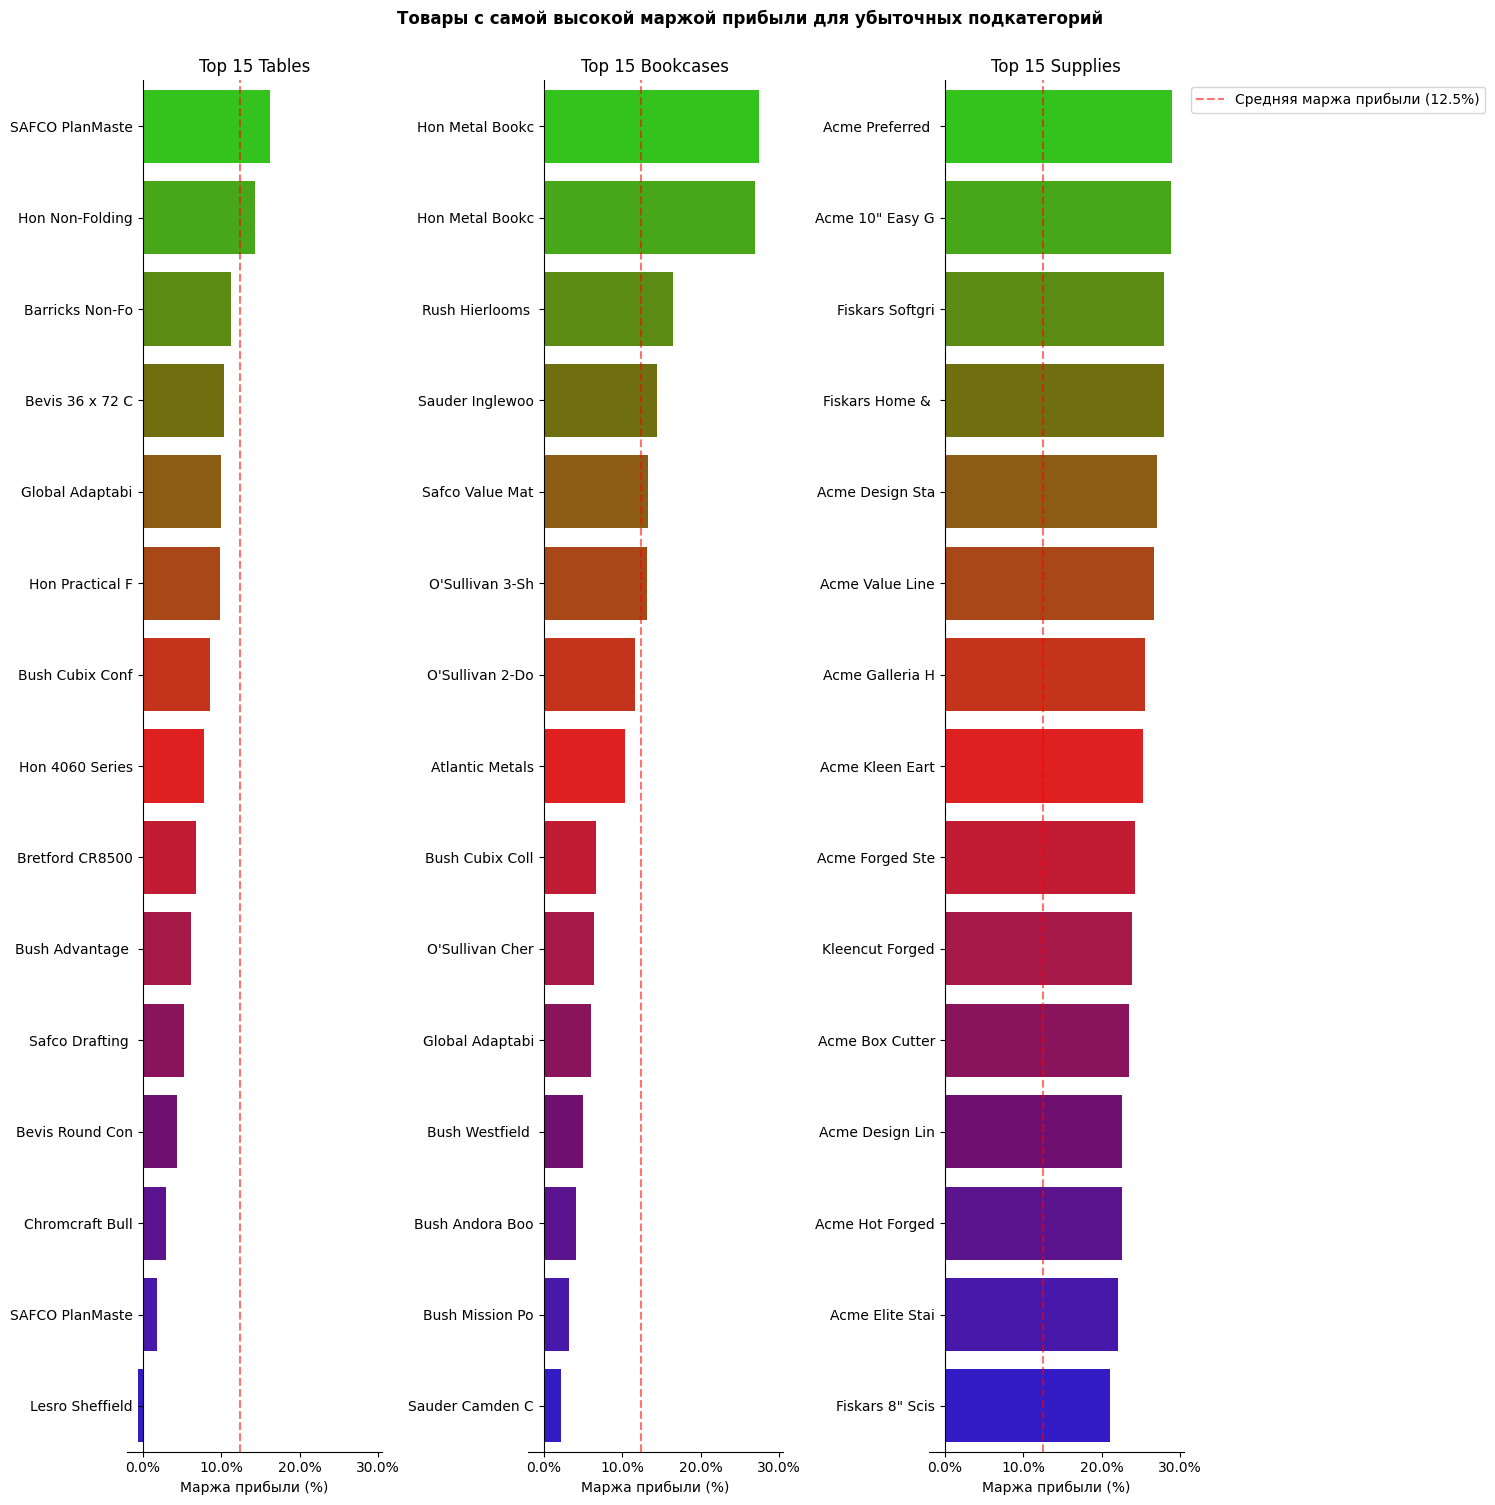

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15,15), ncols=3, sharex=True)

#Создаим графики маржи прибыли для трех убыточных подкатегорий
sns.barplot(y=tables.index[:15], x=tables["profit_margin"][:15], ax=ax1,
           dodge=False, palette="brg_r")
sns.barplot(y=bookcases.index[:15], x=bookcases["profit_margin"][:15], ax=ax2,
           dodge=False, palette="brg_r")
sns.barplot(y=supplies.index[:15], x=supplies["profit_margin"][:15], ax=ax3,
           dodge=False, palette="brg_r")

#Функция, которая укорачивает длинные названия товаров на оси Y до 15 символов
def fix_labels(ax):
    labels = [label.get_text()[:15] for label in ax.get_ymajorticklabels()]
    ax.set_yticklabels(labels)

    return ax

fix_labels(ax1)
fix_labels(ax2)
fix_labels(ax3)

#Стандартизируем внешний вид всех графиков
def format_bars(ax):
    ax.spines[["top","right"]].set_visible(False)
    ax.spines["left"].set_position("zero")
    ax.set(ylabel=None, xlabel="Маржа прибыли (%)")

    ax.axvline(mean_profit, color="red", label="Средняя маржа прибыли (12.5%)", alpha=0.55, ls="--")

    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))

    return ax

format_bars(ax1)
format_bars(ax2)
format_bars(ax3)

ax1.set_title("Top 15 Tables")
ax2.set_title("Top 15 Bookcases")
ax3.set_title("Top 15 Supplies")

fig.suptitle("Товары с самой высокой маржой прибыли для убыточных подкатегорий", y=1, fontweight="bold")

ax3.legend(bbox_to_anchor=(1,1))


fig.tight_layout()

Маржа в категориях Tables и Bookcases падают очень сильно, даже 15-й товар с самой высокой маржой в Tables продаётся с убытком (из 56 товаров в этой категории). График также показывает, что Supplies имеют очень высокую маржу на многих товарах. Тем не менее, подкатегория в целом продаётся с убытком. Скорее всего, это происходит из-за того, что самые продаваемые товары (с наибольшим доходом и влиянием на прибыль категории) продаются с убытком, тем самым снижая маржу для всей подкатегории. Проверим эту гипотезу.

In [13]:
#Преобразуем значения
supplies["profit"] = supplies["profit"].apply(lambda x: f"{x:.2f}")
supplies["profit_margin"] = supplies["profit_margin"].apply(lambda x: f"{x:.2f}")

supplies.sort_values(by="sales", ascending=False)[:5]

,order_id,order_date,ship_date,ship_mode,customer_id,segment,country,city,state,postal_code,region,product_id,category,sales,quantity,discount,profit,profit_margin
product_name,,,,,,,,,,,,,,,,,,
High Speed Automatic Electric Letter Opener,CA-2014-143917CA-2016-103982CA-2016-136301,7/25/20143/3/20163/13/2016,7/27/20143/8/20163/15/2016,Second ClassStandard ClassSecond Class,KL-16645AA-10315EH-13765,ConsumerConsumerCorporate,United StatesUnited StatesUnited States,San FranciscoRound RockSan Francisco,CaliforniaTexasCalifornia,266895,WestCentralWest,OFF-SU-10000151OFF-SU-10000151OFF-SU-10000151,Office SuppliesOffice SuppliesOffice Supplies,17030.312,11,0.2,-262.00,-0.02
Martin Yale Chadless Opener Electric Letter Opener,US-2015-138303CA-2017-158379CA-2014-102988CA-2...,9/3/20159/22/20174/5/201412/19/20173/13/20171/...,9/7/20159/26/20174/9/201412/21/20173/20/20171/...,Standard ClassSecond ClassSecond ClassFirst Cl...,MG-18145JA-15970GM-14695AC-10450SE-20110CP-12085,ConsumerConsumerCorporateConsumerConsumerCorpo...,United StatesUnited StatesUnited StatesUnited ...,PhiladelphiaPhiladelphiaAlexandriaLafayetteDen...,PennsylvaniaPennsylvaniaVirginiaLouisianaColor...,277104,EastEastSouthSouthWestCentral,OFF-SU-10002881OFF-SU-10002881OFF-SU-10002881O...,Office SuppliesOffice SuppliesOffice SuppliesO...,16656.200,22,0.6,-1299.18,-0.08
Compact Automatic Electric Letter Opener,CA-2017-122707US-2016-142685CA-2014-137589US-2...,4/16/20176/23/201611/3/20149/12/20145/8/20155/...,4/18/20176/30/201611/8/20149/19/20145/15/20155...,First ClassStandard ClassStandard ClassStandar...,EB-13750MG-17695MS-17770TA-21385NW-18400CS-121...,CorporateConsumerConsumerHome OfficeConsumerCo...,United StatesUnited StatesUnited StatesUnited ...,HooverBuffaloLancasterOlatheNew York CitySan F...,AlabamaNew YorkPennsylvaniaKansasNew YorkCalif...,354385,SouthEastEastCentralEastWestEastWest,OFF-SU-10000157OFF-SU-10000157OFF-SU-10000157O...,Office SuppliesOffice SuppliesOffice SuppliesO...,2982.750,26,0.4,-57.27,-0.02
Premier Automatic Letter Opener,CA-2016-112697CA-2014-101931CA-2017-141425CA-2...,12/18/201610/28/201411/2/20174/4/20174/5/2016,12/20/201610/31/201411/6/20174/5/20174/9/2016,Second ClassFirst ClassSecond ClassFirst Class...,AH-10195TS-21370AR-10825DS-13030JH-16180,CorporateCorporateCorporateHome OfficeConsumer,United StatesUnited StatesUnited StatesUnited ...,TamaracLos AngelesColumbusNew York CityPhilade...,FloridaCaliforniaOhioNew YorkPennsylvania,195746,SouthWestEastEastEast,OFF-SU-10000646OFF-SU-10000646OFF-SU-10000646O...,Office SuppliesOffice SuppliesOffice SuppliesO...,2836.366,14,0.6,-427.86,-0.15
Premier Electric Letter Opener,CA-2016-109869CA-2016-145919CA-2017-119578CA-2...,4/22/201612/18/201612/22/20173/23/20177/21/201...,4/29/201612/23/201612/27/20173/25/20177/27/201...,Standard ClassStandard ClassSecond ClassSecond...,TN-21040HG-14965JG-15310MZ-17515AM-10705ER-138...,Home OfficeCorporateCorporateCorporateConsumer...,United StatesUnited StatesUnited StatesUnited ...,PhoenixLos AngelesProvidenceNew York CitySalem...,ArizonaCaliforniaRhode IslandNew YorkVirginiaN...,405429,WestWestEastEastSouthSouthWestCentral,OFF-SU-10003505OFF-SU-10003505OFF-SU-10003505O...,Office SuppliesOffice SuppliesOffice SuppliesO...,2641.608,24,0.6,-0.00,-0.00


Видим, что 5 самых продаваемых товаров в категории Supplies продаются с отрицательной маржей, что снизило маржу прибыли для всей подкатегории. Наша гипотеза подтверждена.
Далее посмотрим на сегменты и проведем для них анализ.

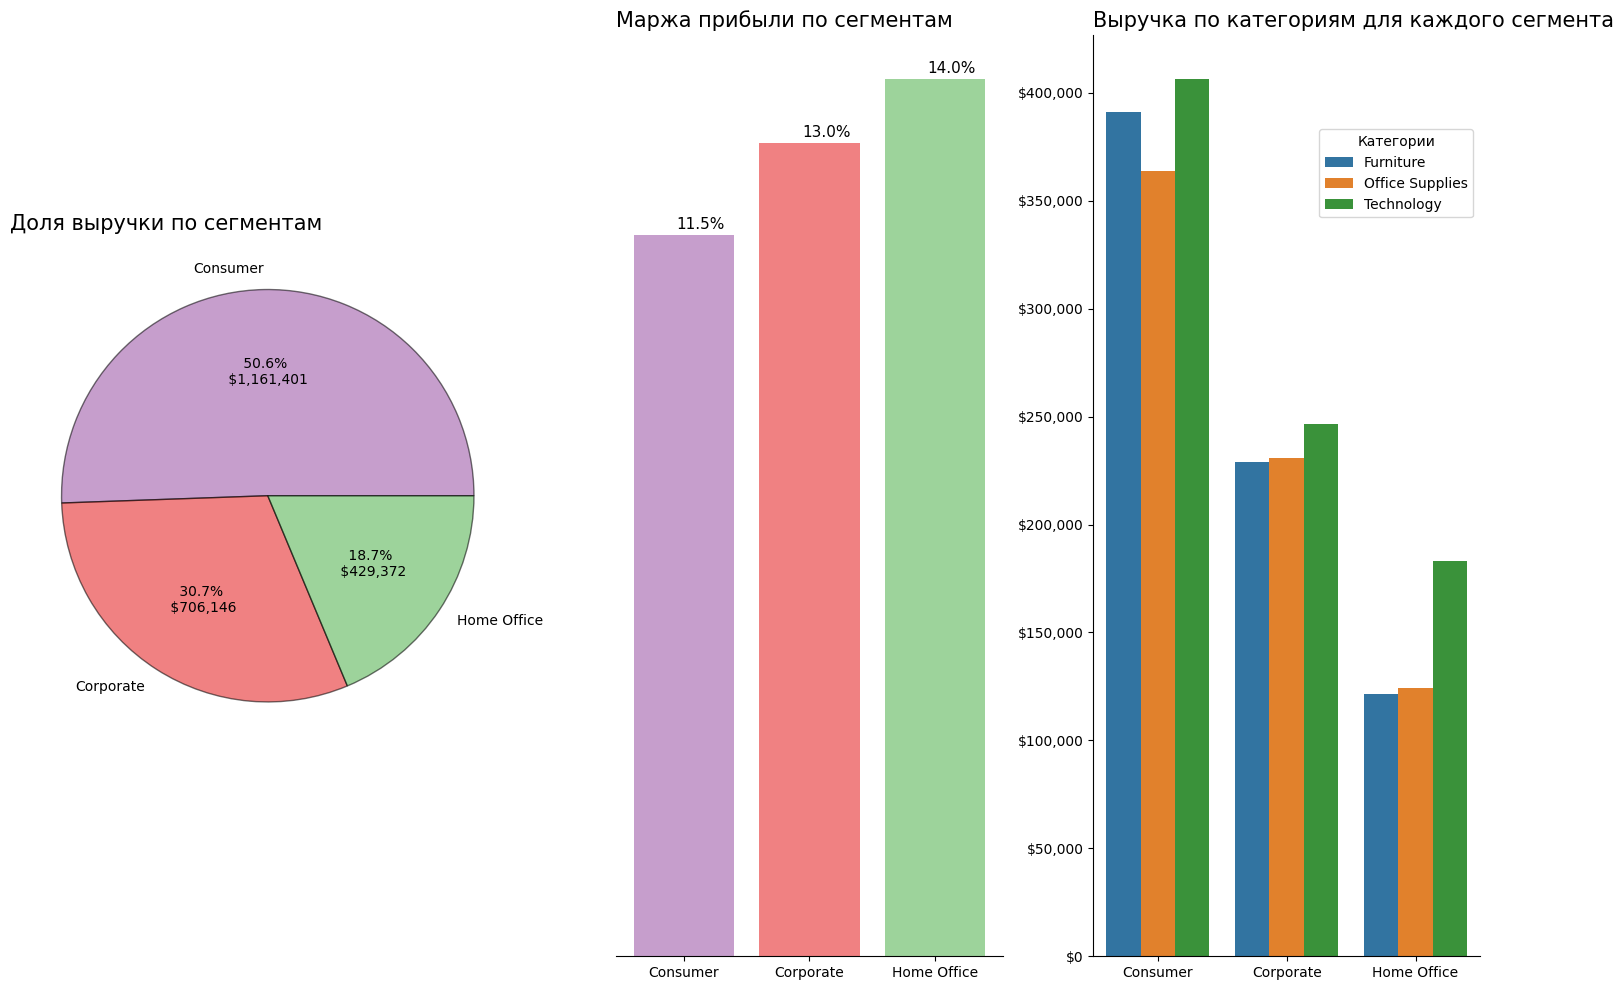

In [14]:
#Группируем по сегментам и суммируем
sales_by_segment = data.groupby("segment").sum()

#Рисуем диаграммы
segment_colors = ["#984ea3" if label == "Consumer" else "#e41a1c" if label == "Corporate" else "#4daf4a" for label in sales_by_segment.index]

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15,10), ncols=3, gridspec_kw={"width_ratios": [1, 0.75, 0.75]})

#Круговая диаграмма с процентной долей выручки
ax1.pie(sales_by_segment["sales"], labels=sales_by_segment.index,
       wedgeprops={"linewidth":1, "edgecolor":"black", "alpha":0.55}, colors=segment_colors,
      autopct=lambda p: f"{p: .1f}% \n ${p*np.sum(sales_by_segment['sales'])/100 :,.0f}")

ax1.set_title("Доля выручки по сегментам", fontdict={"fontsize":15}, loc="left")

sales_by_segment["profit_margin"] = sales_by_segment["profit"] / sales_by_segment["sales"]
sales_by_segment = sales_by_segment[["quantity", "profit", "profit_margin"]].reset_index()

#Вторая диаграмма
ax2.bar(x=sales_by_segment["segment"], height=sales_by_segment["profit_margin"],
           color=segment_colors, alpha=0.55)

ax2.spines[["left", "top", "right"]].set_visible(False)
ax2.tick_params(left=None, labelleft=None)

for p in ax2.patches:
    x, _ = p.get_xy()

    ax2.annotate(f"{p.get_height()*100 :.1f}%", xy=(x+0.34, p.get_height()+0.001), size=11)

ax2.set_title("Маржа прибыли по сегментам", fontdict={"fontsize":15}, loc="left")

segment_and_category = data.groupby(["segment", "category"], as_index=False).sum()

#Третья диаграмма
sns.barplot(x=segment_and_category["segment"], y=segment_and_category["sales"], hue=segment_and_category["category"], ax=ax3)

ax3.spines[["top", "right"]].set_visible(False)
ax3.set_title("Выручка по категориям для каждого сегмента", fontdict={"fontsize":15}, loc="left")
ax3.set(xlabel=None, ylabel=None)

ax3.yaxis.set_major_formatter("${x:,.0f}")

ax3.legend(title="Категории", loc="center right", bbox_to_anchor=(1, 0.85))

fig.tight_layout()

Анализируя сегменты Superstore, видно, что сегмент Consumer вносит наибольший вклад в продажи. Маржа прибыли у сегметна Consumer чуть ниже чем у Corporate и Home Office. Так произошло скорее всего из-за большого объёма продаж мебели (Furniture), которая, как мы видели ранее, имеет самую низкую маржу прибыли среди всех категорий продуктов.
Также из третьей диаграммы видно, что большая часть продаж каждого сегмента приходится на технологии (Technology), которая в среднем имеет высокую маржу прибыли.
Теперь проведем анализ для продаж по штатам.

/tmp/ipython-input-3087086438.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sales_by_state["sales"][:10], y=sales_by_state["state"][:10],


Text(0.5, 1.0, 'Выручка по штатам - Top 10')

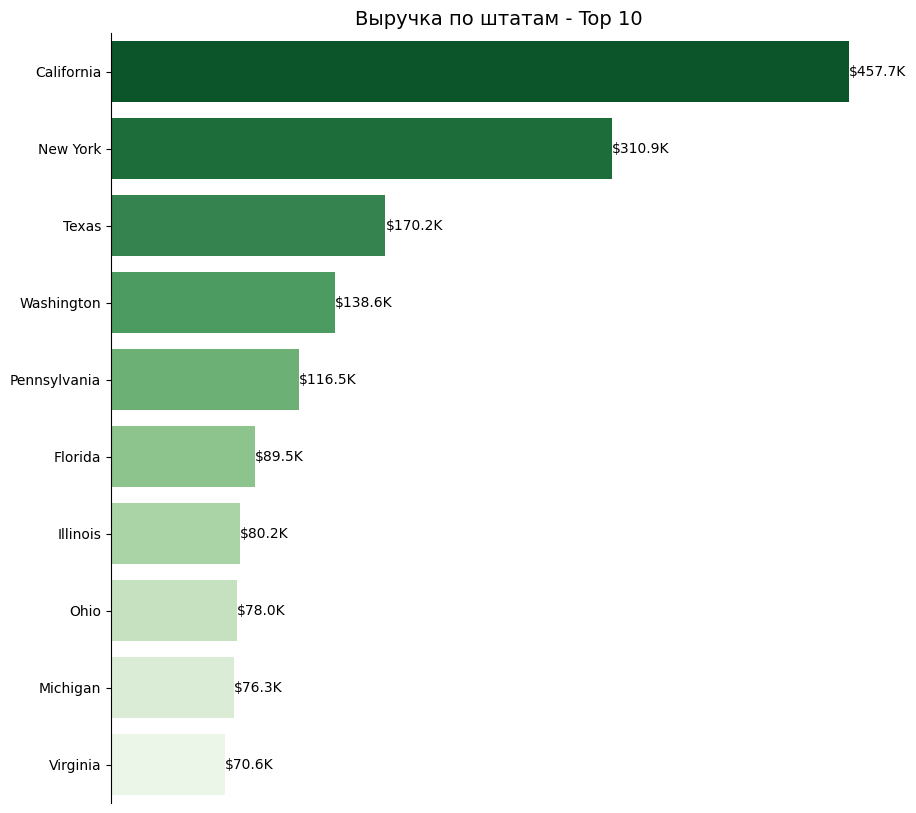

In [15]:
#Группируем данные по штатам, суммируем и сортируем
sales_by_state = data.groupby("state", as_index=False).sum().sort_values(by="sales", ascending=False)

#Расчёт маржи прибыли по штатам
sales_by_state["profit_margin"] = sales_by_state["profit"] / sales_by_state["sales"]

fig, ax = plt.subplots(figsize=(10,10))

#Создаем диаграмму
sns.barplot(x=sales_by_state["sales"][:10], y=sales_by_state["state"][:10],
           ax=ax, palette="Greens_r")

for p in ax.patches:
    _, y = p.get_xy()

    ax.annotate(f"${p.get_width() / 1000 :.1f}K", xy=(p.get_width(), y+0.45))

ax.spines[["top", "right", "bottom"]].set_visible(False)
ax.set(ylabel=None, xlabel=None)
ax.tick_params(labelbottom=None, bottom=None)

ax.set_title("Выручка по штатам - Top 10", fontdict={"fontsize":14})


Падение продаж между первыми двумя штатами и остальными штатами довольно большое, таким образом, компания зависит от поддержания продаж в этих 2 географических сегментах (Калифорния, Нью-Йорк).

/tmp/ipython-input-1467362809.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=no_profit_states["share_of_loss"], y=no_profit_states["state"],
/tmp/ipython-input-1467362809.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=profitable_states["share_of_profit"], y=profitable_states["state"],


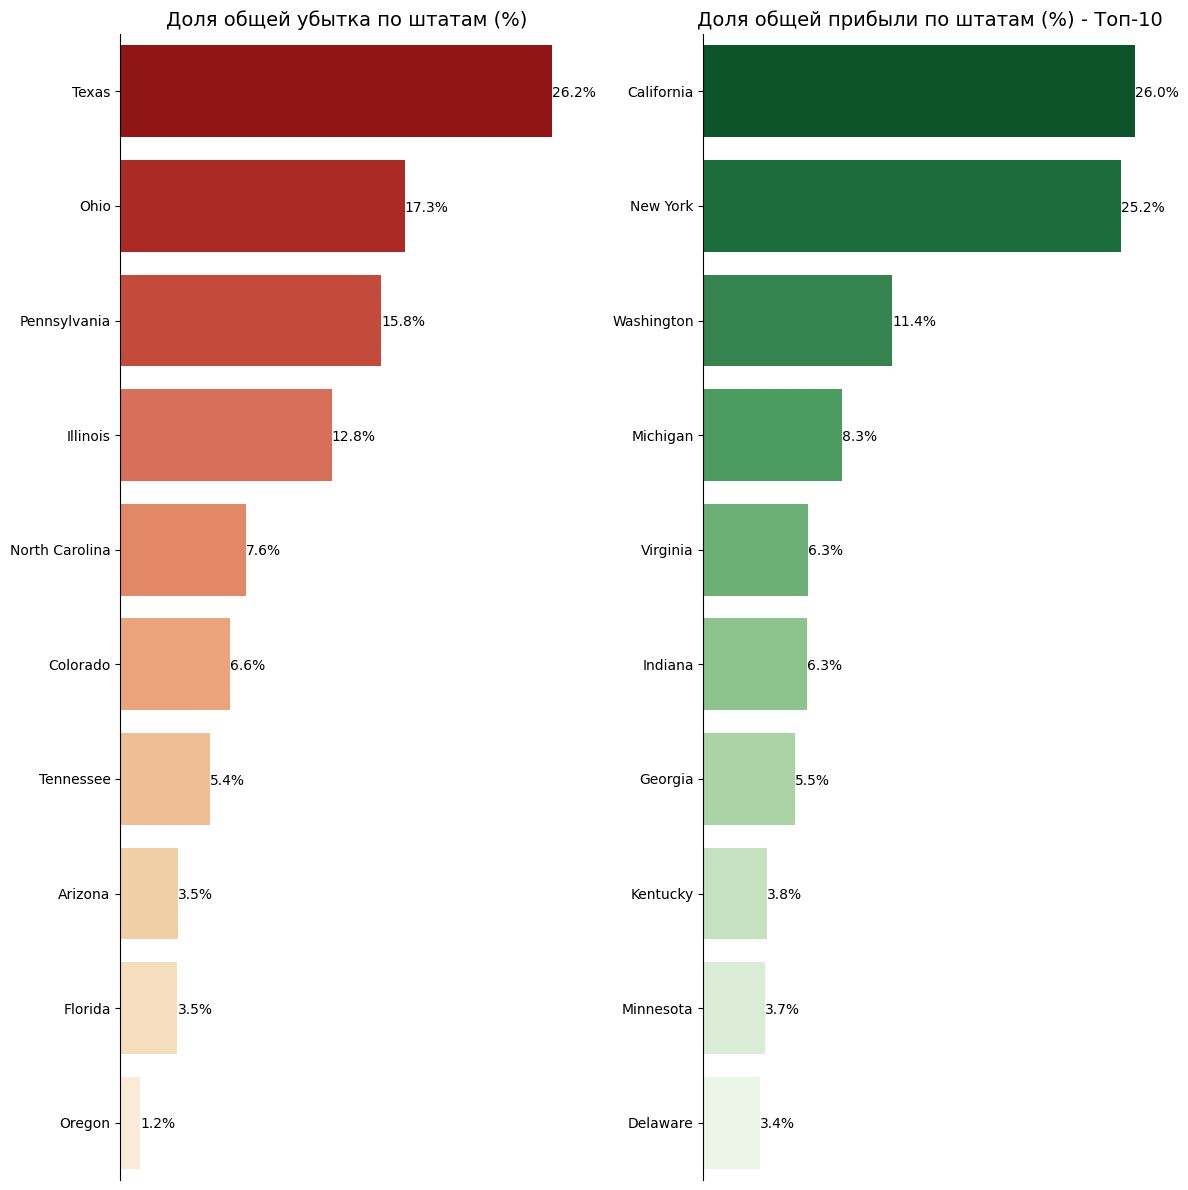

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Фильтрация и расчёт убыточных штатов
no_profit_states = sales_by_state[sales_by_state["profit"] < 0].sort_values(by="profit")[:10]
no_profit_states["share_of_loss"] = no_profit_states["profit"] / no_profit_states["profit"].sum()

# Фильтрация и расчёт прибыльных штатов
profitable_states = sales_by_state[sales_by_state["profit"] > 0].sort_values(by="profit", ascending=False)[:10]
profitable_states["share_of_profit"] = profitable_states["profit"] / profitable_states["profit"].sum()

# Создание двух графиков
fig, (ax1, ax2) = plt.subplots(figsize=(12, 12), ncols=2)

sns.barplot(x=no_profit_states["share_of_loss"], y=no_profit_states["state"],
            ax=ax1, palette="OrRd_r")

sns.barplot(x=profitable_states["share_of_profit"], y=profitable_states["state"],
           ax=ax2, palette="Greens_r")
#Отчистка бар-чартов от ненужных элементов
def clean_hbar(ax):
    ax.spines[["bottom" ,"top", "right"]].set_visible(False)
    ax.set(ylabel=None, xlabel=None)
    ax.tick_params(bottom=False, labelbottom=False)

    return ax
#подпись доли прибыли/убытков на бар-чартах
def annotate_hbar(ax):
    for p in ax.patches:
        _, y = p.get_xy()
        ax.annotate(f"{p.get_width()*100 :.1f}%", xy=(p.get_width(), y+0.45))

    return ax

annotate_hbar(ax1)
annotate_hbar(ax2)

clean_hbar(ax1)
clean_hbar(ax2)

ax1.set_title("Доля общей убытка по штатам (%)", fontdict={"fontsize":14})
ax2.set_title("Доля общей прибыли по штатам (%) - Топ-10", fontdict={"fontsize":14})

fig.tight_layout()


Видим, что некоторые штаты, в которох компания делает большую часть своих продаж, на самом деле снижают прибыль, которую компания получает. Например, Техас вносит более четверти убытков, которые компания несёт от своих продаж, хотя он и является их третьим по величине сегментом в плане продаж.

**Суммируя весь анализ мы получаем следующее:**
технологии и Домашний офис имеют в среднем высокую прибыль, а вот Мебель продаются с низкой маржой и даже с убытками для некоторых подкатегорий.
Сегмент Потребитель делает большую часть продаж Superstore, а среди всех сегментов Технологии вносят наибольший вклад в доход.

Более 50%  прибыли магазина приходится на Калифорнию и Нью-Йорк, то  есть магазин довольно сильно географически зависим от поддержания продаж в этих регионах.
Продажи магазина в Техасе (который является третьим по величине штатом по продажам) в целом приносят убытки.

Вот что можно предпринять, чтобы улучшить ситуацию магазина и повысить его доход: прекратить продажи в тех штатах, где в совокупности они несут убытки либо прекратить в этих штатах продажу нерентабельных продуктов, так как убытки могут быть обусловлены типами товаров, продаваемых клиентам в этом штате, или стоимостью доставки в определенные районы, которая снижает их прибыль. Но перед этим следует провести анализ корзины покупок, который проверяет, являются ли низкорентабельные или нерентабельные товары частью корзин, которые в совокупности приносят прибыль.